In [1]:
import traceback
import networkx as nx
from matplotlib import pyplot as plt

import sys
import os

#For deeper_extraction and simplify_rail, add to path
# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to the Python path
parent_dir = os.path.join(current_dir, '..')
sys.path.append(parent_dir)

sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
import pickle
from osm_flex.download import *
from osm_flex.extract import *
from osm_flex.config import *
import osm_flex.clip as cp
import geojson
import sys
from shapely.geometry import shape
from damagescanner.vector import *
from pathlib import Path
from ra2ce_multi_network.deeper_extraction import filter_on_other_tags
from ra2ce_multi_network.simplify_rail import _nx_to_network


In [2]:


# load an earlier merged network
root_folder = Path(
    r'C:\Users\peregrin\osm')
merged_rail_graph_file = root_folder.joinpath(f'output_graph/merged_rail_network_od_mapped.p')
with open(merged_rail_graph_file, 'rb') as handle:
    merged_rail_graph = pickle.load(handle)


# # Load a merged network if not willing to run the merge function in this Notebook and have the merged stored
# merged_rail_network_file = root_folder.joinpath(f'merged_rail_network.geojson')
# with open(merged_rail_network_file, 'rb') as handle:
#     merged_rail_network = pickle.load(handle)


In [3]:
G=nx.MultiDiGraph(merged_rail_graph)

In [4]:
G.edges[(2, 3, 0)]

{'from_id': 2,
 'to_id': 3,
 'osm_id': '4349788',
 'railway': 'rail',
 'name': 'Voreifelbahn',
 'gauge': '1435',
 'electrified': 'no',
 'voltage': '',
 'bridge': 'yes',
 'maxspeed': '100',
 'service': '',
 'tunnel': 'None',
 'other_tags': '"layer"=>"1","operator"=>"DB Netz AG","passenger_lines"=>"2","proposed:electrified"=>"contact_line","proposed:frequency"=>"16.7","proposed:voltage"=>"15000","railway:etcs"=>"no","railway:lzb"=>"no","railway:pzb"=>"yes","railway:radio"=>"gsm-r","railway:traffic_mode"=>"passenger","ref"=>"2645","tracks"=>"1","usage"=>"main","wikidata"=>"Q1699351","wikipedia"=>"de:Voreifelbahn"',
 '_11': '"passenger"',
 'usage': '"main"',
 'geometry': <LINESTRING (7.02 50.705, 7.02 50.704, 7.02 50.704)>,
 'id': 818,
 'length': 0.07294187178244692}

In [5]:
G.nodes[10]

{'id': 10,
 'geometry': <POINT (7.08 50.737)>,
 'degree': 3.0,
 'x': 7.0795917,
 'y': 50.7369301,
 'node_fid': 10}

In [6]:
#G.edges.capacity=10
#G.edges.weight=1

for _, _, attr in G.edges(data=True):
    attr['weight']=1
    attr['capacity']=10

for _, attr in G.nodes(data=True):
    attr['demand']=0
    attr['pos']=(attr['x'],attr['y'])

G.nodes[10]['demand']=0
G.nodes[100]['demand']=0
G.nodes[2944]['demand']=9
G.nodes[2945]['demand']=-9


In [8]:

#SA
max_weight_graph = max(attr['weight'] for _, _, attr in G.edges(data=True))
print('Max weight: '+str(max_weight_graph))
max_capacity_graph = max(attr['capacity'] for _, _, attr in G.edges(data=True))
print('Max capacity: '+str(max_capacity_graph))

G_v=G.copy()
#convert to int
for u, v, key, attr in G.edges(keys=True, data=True):
    attr['weight'] = int(round(attr['weight'] * 10e3, 0))
    attr['capacity'] = int(max_capacity_graph * 100)
    G_v.add_edge((str(u) + '_d'), (str(v) + '_d'), **attr)

for u in G.nodes:
    G_v.add_edge(u,(str(u) + '_d'),capacity=max_capacity_graph*100,weight=max_weight_graph*1e3)
    G_v.add_edge((str(u) + '_d'),u,capacity=max_capacity_graph*100,weight=0)


Max weight: 1
Max capacity: 10


In [9]:
import re

extract_numeric_part = lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else None


for u,attr in G_v.nodes(data=True):
    if isinstance(u, int): pass
    elif isinstance(u, str): 
        #print(G_v[extract_numeric_part(u)]['pos'])
        attr['pos']=(G_v.nodes[extract_numeric_part(u)]['pos'][0]+0.0005,G_v.nodes[extract_numeric_part(u)]['pos'][-1]+0.0005)
    
     
    # attr['pos']=
    
    #G_v.add_edge(u,(str(u) + '_d'),capacity=max_capacity_graph*100,weight=max_weight_graph*1e3)
    #G_v.add_edge((str(u) + '_d'),u,capacity=max_capacity_graph*100,weight=0)


In [10]:

#G.nodes[2944]
#G_v.nodes[2945]
G_v.nodes['2945_d']
#G_v.edges[(2945,'2945_d',0)]

{'pos': (7.2501131, 50.3389918)}

In [11]:

pos=nx.get_node_attributes(G_v, 'pos')



In [12]:

mcf=nx.min_cost_flow(G_v)
print('Minimum cost flow: '+str(mcf))

flow_dict = mcf

# G_v.graph["crs"] = "EPSG:4326"
# exporter = MultiGraphNetworkExporter(basename="test_graph_flow_nodes", export_types=["shp", "pickle"])
# exporter.export_to_shp(output_dir=Path(r"c:\Users\peregrin\experiments\output"), export_data=G_v)
# exporter.export_to_pickle(output_dir=Path(r"c:\Users\peregrin\experiments\output"), export_data=G_v)

 
# TODO define regional unit (river basin? NUTS? ==> Discuss stictching with Kees/Elco/Sahand)


Minimum cost flow: {2: {3: {0: 0}, 2252: {0: 0}, '2_d': {0: 0}}, 3: {2: {0: 0}, 3008: {0: 0}, '3_d': {0: 0}}, 4: {2385: {0: 0}, 2566: {0: 0}, '4_d': {0: 0}}, 5: {2385: {0: 0}, 46: {0: 0}, 58: {0: 0}, '5_d': {0: 0}}, 6: {7: {0: 0}, 2685: {0: 0}, '6_d': {0: 0}}, 7: {6: {0: 0}, 32: {0: 0}, '7_d': {0: 0}}, 8: {478: {0: 0}, 472: {0: 0}, '8_d': {0: 0}}, 10: {2386: {0: 0}, 55: {0: 0}, 334: {0: 0}, '10_d': {0: 0}}, 11: {2386: {0: 0}, 2567: {0: 0}, '11_d': {0: 0}}, 13: {2723: {0: 0}, 2722: {0: 0}, 2714: {0: 0}, '13_d': {0: 0}}, 14: {15: {0: 0}, 16: {0: 0}, '14_d': {0: 0}}, 15: {14: {0: 0}, 2720: {0: 0}, '15_d': {0: 0}}, 16: {14: {0: 0}, 17: {0: 0}, '16_d': {0: 0}}, 17: {16: {0: 0}, 2700: {0: 0}, '17_d': {0: 0}}, 18: {2680: {0: 0}, 19: {0: 0}, 332: {0: 0}, '18_d': {0: 0}}, 19: {18: {0: 0}, 824: {0: 0}, '19_d': {0: 0}}, 20: {1268: {0: 0}, 480: {0: 0}, '20_d': {0: 0}}, 23: {316: {0: 0}, 115: {0: 0}, '23_d': {0: 0}}, 24: {25: {0: 0}, 132: {0: 0}, '24_d': {0: 0}}, 25: {24: {0: 0}, 1288: {0: 0}, 1306

Minimum cost flow: {2: {3: {0: 0}, 2252: {0: 0}, '2_d': {0: 0}}, 3: {2: {0: 0}, 3008: {0: 0}, '3_d': {0: 0}}, 4: {2385: {0: 0}, 2566: {0: 0}, '4_d': {0: 0}}, 5: {2385: {0: 0}, 46: {0: 0}, 58: {0: 0}, '5_d': {0: 0}}, 6: {7: {0: 0}, 2685: {0: 0}, '6_d': {0: 0}}, 7: {6: {0: 0}, 32: {0: 0}, '7_d': {0: 0}}, 8: {478: {0: 0}, 472: {0: 0}, '8_d': {0: 0}}, 10: {2386: {0: 0}, 55: {0: 0}, 334: {0: 0}, '10_d': {0: 0}}, 11: {2386: {0: 0}, 2567: {0: 0}, '11_d': {0: 0}}, 13: {2723: {0: 0}, 2722: {0: 0}, 2714: {0: 0}, '13_d': {0: 0}}, 14: {15: {0: 0}, 16: {0: 0}, '14_d': {0: 0}}, 15: {14: {0: 0}, 2720: {0: 0}, '15_d': {0: 0}}, 16: {14: {0: 0}, 17: {0: 0}, '16_d': {0: 0}}, 17: {16: {0: 0}, 2700: {0: 0}, '17_d': {0: 0}}, 18: {2680: {0: 0}, 19: {0: 0}, 332: {0: 0}, '18_d': {0: 0}}, 19: {18: {0: 0}, 824: {0: 0}, '19_d': {0: 0}}, 20: {1268: {0: 0}, 480: {0: 0}, '20_d': {0: 0}}, 23: {316: {0: 0}, 115: {0: 0}, '23_d': {0: 0}}, 24: {25: {0: 0}, 132: {0: 0}, '24_d': {0: 0}}, 25: {24: {0: 0}, 1288: {0: 0}, 1306

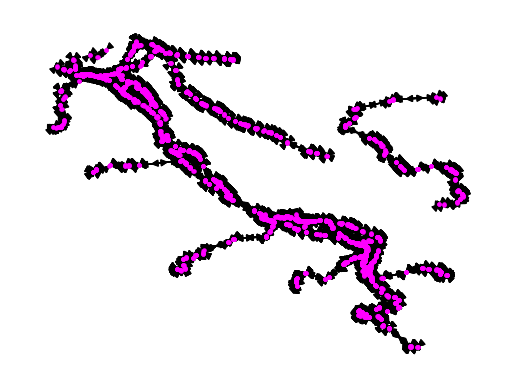

In [ ]:


draw_edges=nx.draw_networkx_edges(G_v,pos)
nx.draw(G_v, pos, 
        with_labels=False,
        node_size=5,
        node_color='magenta')


# G_v.graph["crs"] = "EPSG:4326"
# exporter = MultiGraphNetworkExporter(basename="test_graph_flow_nodes", export_types=["shp", "pickle"])
# exporter.export_to_shp(output_dir=Path(r"c:\Users\peregrin\experiments\output"), export_data=G_v)
# exporter.export_to_pickle(output_dir=Path(r"c:\Users\peregrin\experiments\output"), export_data=G_v)

 
# TODO define regional unit (river basin? NUTS? ==> Discuss stictching with Kees/Elco/Sahand)


In [ ]:

#Function to calculate capacity based on hazard and recovery rate
#Input: Network
def update_capacity(G,haz,recovery):
    if haz is None:
        for u, v, key, attr in G.edges(keys=True, data=True):
            if ('_' in u) or ('_' in v):
                continue
            else:
                G.edges[(u,v,key)]['capacity']+=G.edges[(u,v,key)]['capacity0']*(recovery)
                if G.edges[(u,v,key)]['capacity']<0: 
                    G.edges[(u,v,key)]['capacity']=0
                elif G.edges[(u,v,key)]['capacity']>G.edges[(u,v,key)]['capacity0']:
                    G.edges[(u,v,key)]['capacity']=G.edges[(u,v,key)]['capacity0']    
    else:
        print(f'Hazard of intensity {haz.intensity} in positions: {haz.affected_area}')
        for u, v, key, attr in G.edges(keys=True, data=True):
            if ('_' in u) or ('_' in v):
                continue
            elif (G.nodes[u]['pos'] in haz.affected_area) or (G.nodes[v]['pos'] in haz.affected_area):
                damage=haz.intensity*0.3 #dummy value for intensity damage function
                G.edges[(u,v,key)]['capacity']+=G.edges[(u,v,key)]['capacity0']*(recovery-damage)
                if G.edges[(u,v,key)]['capacity']<0: 
                    G.edges[(u,v,key)]['capacity']=0
                elif G.edges[(u,v,key)]['capacity']>G.edges[(u,v,key)]['capacity0']:
                    G.edges[(u,v,key)]['capacity']=G.edges[(u,v,key)]['capacity0']

            else: print(f'{u}->{v} not in hazard area')
       
    return G


class Hazard:
    def __init__(self,affected_area=[],intensity=1.0):
        self.affected_area=affected_area
        self.intensity=intensity
    

affected_area1=[(1,1),(2,2)]
intensity1=0.7
haz1=Hazard(affected_area1,intensity1)

affected_area2=[(1,-1),(2,1)]
intensity2=0.2
haz2=Hazard(affected_area2,intensity2)

#--------------------------------------------------------------
#--------------------------------------------------------------
#--------------------------------------------------------------

t=[1,2,3,4,5,6,7,8,9,10,11] #timeseries of timesteps
recovery=0.01 #recovery rate, 1% per time unit. 0.01 means recovery of 1% of asset capacity
distress=[0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0]
flows=[mcf]
for i in t:
    print(f'Timestep: {i}')
    if distress[i]==0: haz=None
    else: haz=eval('haz'+str(distress[i]))

    G_v=update_capacity(G_v,haz,recovery)
    flow_dict=nx.min_cost_flow(G_v)
    flows.append(flow_dict)

    edges_done = []
    
    for n in flow_dict.keys():
        #print(f't: {i}, n:{n}')
        to_nodes = flow_dict[n].keys()
        for to_node in to_nodes:
            ks = flow_dict[n][to_node].keys()
            for k in ks:
                # print(i, n, to_node)
                if (n, to_node, k) in edges_done:
                    continue
                flow = flow_dict[n][to_node][k]
                #print(f'flow in edge: {flow}')
                if '_' not in to_node:
                    try:
                        G_v[n][to_node][k]["flow"] = flow
                    except KeyError as e:
                        print("not found")
                        print(repr(e))
                if flow > 0:
                    try:
                        if '_' in to_node and '_' not in n:
                            # G_v.nodes[n]["flow"] = flow
                            to_node_int = int(to_node.split('_')[0])
                            if to_node_int == n:
                                G_v.nodes[n]["bottleneck"] = "yes"
                                G_v[n][to_node][k]["bottleneck"] = "yes"
                            print(f'Bottleneck in: {n}. Overflow: {flow}')    
                        elif '_' in n and '_' not in to_node:
                            n_int = str(int(n.split('_')[0]))
                            # G_v.nodes[n_int]["flow"] = flow
                            if n_int == n:
                                G_v.nodes[n_int]["bottleneck"] = "yes"
                                G_v[n_int][to_node][k]["bottleneck"] = "yes"
                        elif '_' in n and '_' in to_node:
                            print(f'Overflow through {n} and {to_node}')
                        elif '_' not in n and '_' not in to_node:
                            G_v.nodes[n]["bottleneck"] = "no"
                            # G_v.nodes[n]["flow"] = flow
                            G_v[n][to_node][k]["bottleneck"] = "no"
                        else:
                            print("WEIRD")
                    except KeyError as e:
                        print(f'KeyError: From {n} to {to_node}')
                        print(repr(e))
                    
                    edges_done.append((n, to_node, k))


















# # Plot
# sections = geopandas.read_file(r'C:\Users\peregrin\experiments\railways_de_20230907\rail_clip.shp')

# G = momepy.gdf_to_nx(sections, approach="primal")

# positions = {n: [n[0], n[1]] for n in list(G.nodes)}
# f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
# sections.plot(color="k", ax=ax[0])
# for i, facet in enumerate(ax):
#     facet.set_title(("Railways", "Graph")[i])
#     facet.axis("off")
# nx.draw(G, positions, ax=ax[1], node_size=5)

